## Load data

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import os
import pandas as pd

plv_dir = "./plv_matrices/plv_matrices"

# Fixed channel list
ch_names = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Fz", "Cz", "Pz"
]

plv_features = []

for filename in os.listdir(plv_dir):
    if filename.endswith(".npy"):
        print(f"Processing {filename}...")
        subject_band = filename.replace("_plv.npy", "")
        subject_id, band = subject_band.split("_", 1)

        plv_matrix = np.load(os.path.join(plv_dir, filename))

        # Use manually defined channel list
        upper_indices = np.triu_indices(len(ch_names), k=1)
        pair_labels = [f"{ch_names[i]}-{ch_names[j]}" for i, j in zip(*upper_indices)]
        plv_values = plv_matrix[upper_indices]

        row = {"subject": subject_id, "band": band}
        row.update(dict(zip(pair_labels, plv_values)))
        plv_features.append(row)

# Create final feature DataFrame
plv_df = pd.DataFrame(plv_features)

# Save to CSV
plv_df.to_csv("plv_features.csv", index=False)
print("✅ Saved: plv_features.csv")


Processing sub-001_alpha_plv.npy...
Processing sub-001_beta_plv.npy...
Processing sub-001_delta_plv.npy...
Processing sub-001_gamma_plv.npy...
Processing sub-001_theta_plv.npy...
Processing sub-002_alpha_plv.npy...
Processing sub-002_beta_plv.npy...
Processing sub-002_delta_plv.npy...
Processing sub-002_gamma_plv.npy...
Processing sub-002_theta_plv.npy...
Processing sub-003_alpha_plv.npy...
Processing sub-003_beta_plv.npy...
Processing sub-003_delta_plv.npy...
Processing sub-003_gamma_plv.npy...
Processing sub-003_theta_plv.npy...
Processing sub-004_alpha_plv.npy...
Processing sub-004_beta_plv.npy...
Processing sub-004_delta_plv.npy...
Processing sub-004_gamma_plv.npy...
Processing sub-004_theta_plv.npy...
Processing sub-005_alpha_plv.npy...
Processing sub-005_beta_plv.npy...
Processing sub-005_delta_plv.npy...
Processing sub-005_gamma_plv.npy...
Processing sub-005_theta_plv.npy...
Processing sub-006_alpha_plv.npy...
Processing sub-006_beta_plv.npy...
Processing sub-006_delta_plv.npy..

In [5]:
# Load PLV features
plv_df = pd.read_csv("plv_features.csv")

# Load participant metadata (e.g., group, MMSE)
participants = pd.read_csv("participants.tsv", sep="\t")

# Fix ID column
participants["subject"] = participants["participant_id"]

# Merge on subject ID
merged_df = plv_df.merge(participants, on="subject")

# Check result
print(merged_df[["subject", "band", "Group"]].head())


   subject   band Group
0  sub-001  alpha     A
1  sub-001   beta     A
2  sub-001  delta     A
3  sub-001  gamma     A
4  sub-001  theta     A


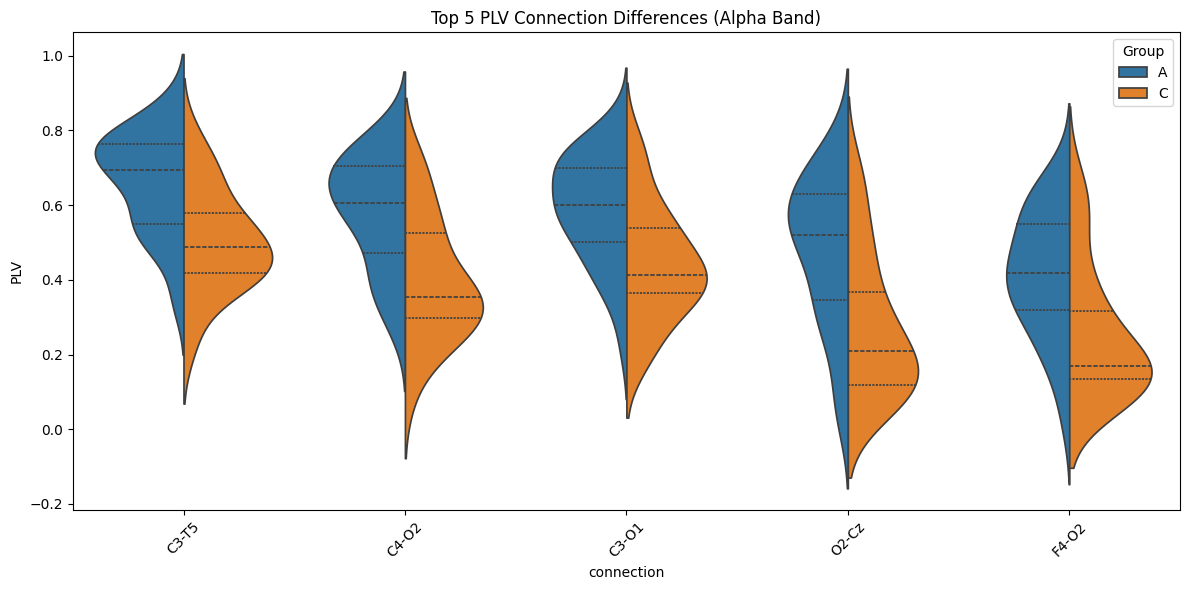

In [6]:
alpha_df = merged_df[merged_df["band"] == "alpha"].copy()
alpha_df = alpha_df[alpha_df["Group"].isin(["A", "C"])]  # keep only A and C groups

from scipy.stats import ranksums

# Identify all PLV columns (exclude meta columns)
meta_cols = ["subject", "band", "Group", "Gender", "Age", "MMSE", "participant_id"]
plv_cols = [col for col in alpha_df.columns if col not in meta_cols]

# Run Wilcoxon test for each PLV pair
pvals = []

for col in plv_cols:
    group_a = alpha_df[alpha_df["Group"] == "A"][col]
    group_c = alpha_df[alpha_df["Group"] == "C"][col]

    stat, p = ranksums(group_a, group_c)
    pvals.append((col, p))

# Sort by smallest p-value
top_pairs = sorted(pvals, key=lambda x: x[1])[:5]
top_pair_names = [pair[0] for pair in top_pairs]


import seaborn as sns
import matplotlib.pyplot as plt

# Make long-form DataFrame for seaborn
plot_df = alpha_df.melt(id_vars=["subject", "Group"], value_vars=top_pair_names,
                        var_name="connection", value_name="PLV")

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="connection", y="PLV", hue="Group", data=plot_df, split=True, inner="quart")
plt.title("Top 5 PLV Connection Differences (Alpha Band)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


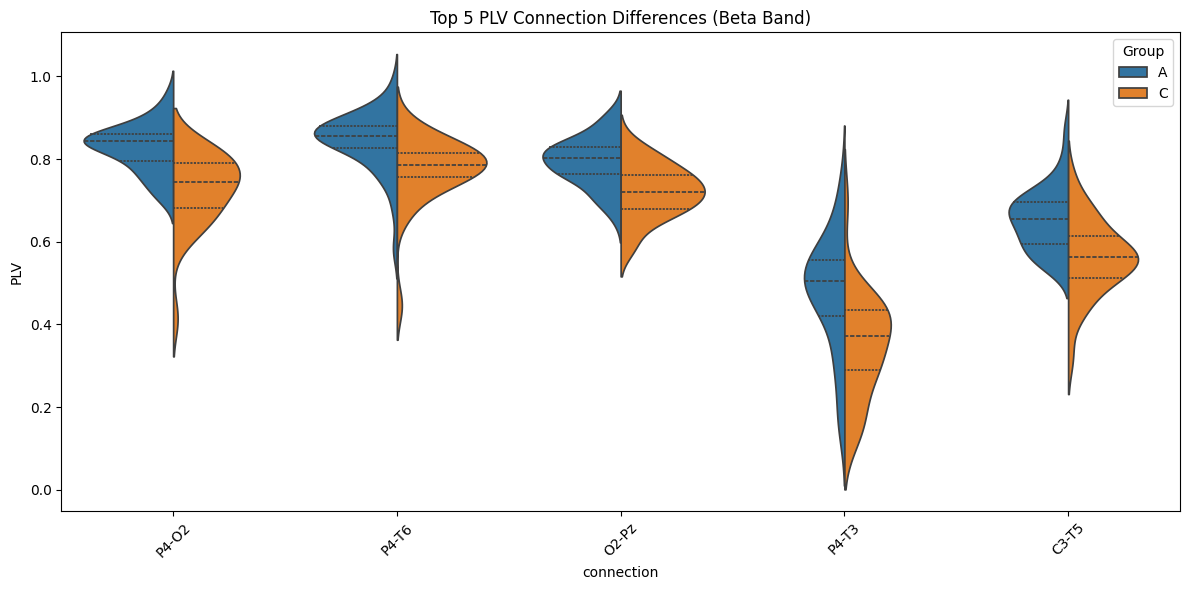

In [11]:
# do the same for beta
beta_df = merged_df[merged_df["band"] == "beta"].copy()
beta_df = beta_df[beta_df["Group"].isin(["A", "C"])]  # keep only A and C groups

# Identify all PLV columns (exclude meta columns)
from scipy.stats import ranksums

# Identify all PLV columns (exclude meta columns)
meta_cols = ["subject", "band", "Group", "Gender", "Age", "MMSE", "participant_id"]
plv_cols = [col for col in beta_df.columns if col not in meta_cols]

# Run Wilcoxon test for each PLV pair
pvals = []

for col in plv_cols:
    group_a = beta_df[beta_df["Group"] == "A"][col]
    group_c = beta_df[beta_df["Group"] == "C"][col]

    stat, p = ranksums(group_a, group_c)
    pvals.append((col, p))

# Sort by smallest p-value
top_pairs = sorted(pvals, key=lambda x: x[1])[:5]
top_pair_names = [pair[0] for pair in top_pairs]


import seaborn as sns
import matplotlib.pyplot as plt

# Make long-form DataFrame for seaborn
plot_df = beta_df.melt(id_vars=["subject", "Group"], value_vars=top_pair_names,
                        var_name="connection", value_name="PLV")

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="connection", y="PLV", hue="Group", data=plot_df, split=True, inner="quart")
plt.title("Top 5 PLV Connection Differences (Beta Band)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



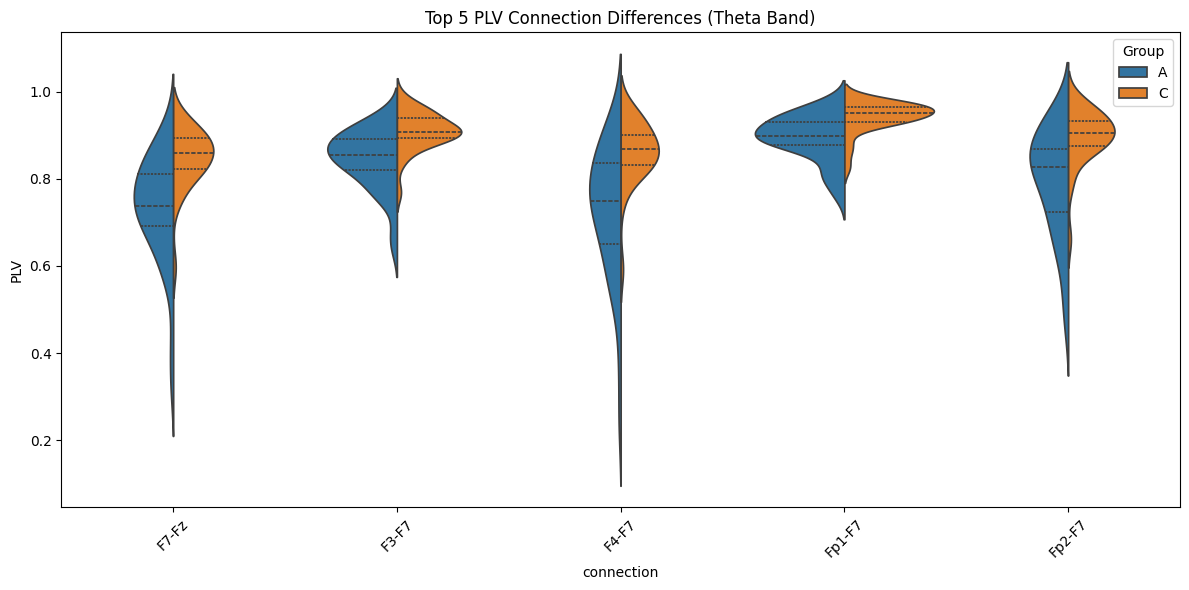

In [12]:
# do the same for theta
theta_df = merged_df[merged_df["band"] == "theta"].copy()
theta_df = theta_df[theta_df["Group"].isin(["A", "C"])]  # keep only A and C groups

# Identify all PLV columns (exclude meta columns)
# Identify all PLV columns (exclude meta columns)
meta_cols = ["subject", "band", "Group", "Gender", "Age", "MMSE", "participant_id"]
plv_cols = [col for col in theta_df.columns if col not in meta_cols]

# Run Wilcoxon test for each PLV pair
pvals = []

for col in plv_cols:
    group_a = theta_df[theta_df["Group"] == "A"][col]
    group_c = theta_df[theta_df["Group"] == "C"][col]

    stat, p = ranksums(group_a, group_c)
    pvals.append((col, p))

# Sort by smallest p-value
top_pairs = sorted(pvals, key=lambda x: x[1])[:5]
top_pair_names = [pair[0] for pair in top_pairs]


import seaborn as sns
import matplotlib.pyplot as plt

# Make long-form DataFrame for seaborn
plot_df = theta_df.melt(id_vars=["subject", "Group"], value_vars=top_pair_names,
                        var_name="connection", value_name="PLV")

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="connection", y="PLV", hue="Group", data=plot_df, split=True, inner="quart")
plt.title("Top 5 PLV Connection Differences (Theta Band)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




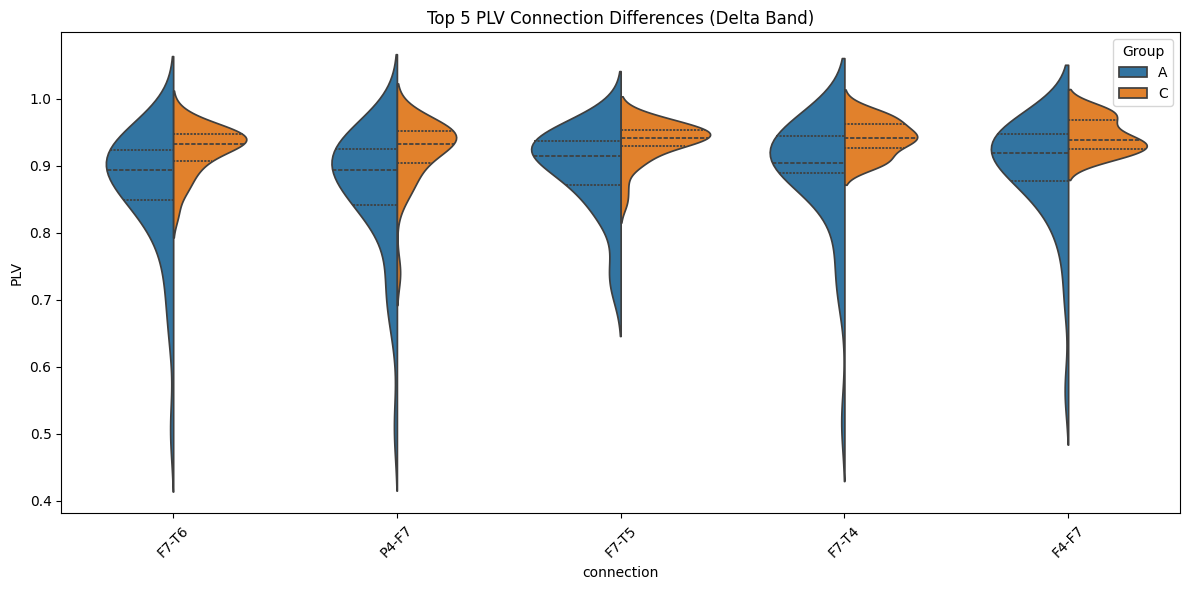

In [13]:
# do the same for delta
delta_df = merged_df[merged_df["band"] == "delta"].copy()
delta_df = delta_df[delta_df["Group"].isin(["A", "C"])]  # keep only A and C groups

# Identify all PLV columns (exclude meta columns)
# Identify all PLV columns (exclude meta columns)
meta_cols = ["subject", "band", "Group", "Gender", "Age", "MMSE", "participant_id"]
plv_cols = [col for col in delta_df.columns if col not in meta_cols]

# Run Wilcoxon test for each PLV pair
pvals = []

for col in plv_cols:
    group_a = delta_df[delta_df["Group"] == "A"][col]
    group_c = delta_df[delta_df["Group"] == "C"][col]

    stat, p = ranksums(group_a, group_c)
    pvals.append((col, p))

# Sort by smallest p-value
top_pairs = sorted(pvals, key=lambda x: x[1])[:5]
top_pair_names = [pair[0] for pair in top_pairs]


import seaborn as sns
import matplotlib.pyplot as plt

# Make long-form DataFrame for seaborn
plot_df = delta_df.melt(id_vars=["subject", "Group"], value_vars=top_pair_names,
                        var_name="connection", value_name="PLV")

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="connection", y="PLV", hue="Group", data=plot_df, split=True, inner="quart")
plt.title("Top 5 PLV Connection Differences (Delta Band)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


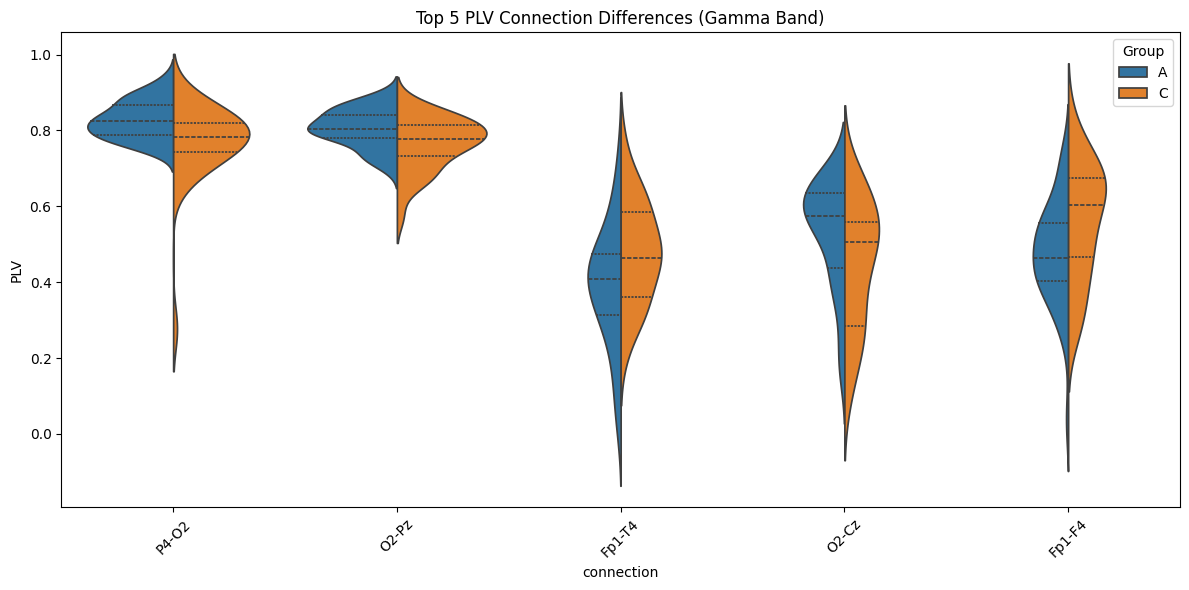

In [16]:

# do the same for gamma

gamma_df = merged_df[merged_df["band"] == "gamma"].copy()
gamma_df = gamma_df[gamma_df["Group"].isin(["A", "C"])]  # keep only A and C groups

# Identify all PLV columns (exclude meta columns)

# Identify all PLV columns (exclude meta columns)
meta_cols = ["subject", "band", "Group", "Gender", "Age", "MMSE", "participant_id"]
plv_cols = [col for col in gamma_df.columns if col not in meta_cols]

# Run Wilcoxon test for each PLV pair
pvals = []

for col in plv_cols:
    group_a = gamma_df[gamma_df["Group"] == "A"][col]
    group_c = gamma_df[gamma_df["Group"] == "C"][col]

    stat, p = ranksums(group_a, group_c)
    pvals.append((col, p))

# Sort by smallest p-value
top_pairs = sorted(pvals, key=lambda x: x[1])[:5]
top_pair_names = [pair[0] for pair in top_pairs]


import seaborn as sns
import matplotlib.pyplot as plt

# Make long-form DataFrame for seaborn
plot_df = gamma_df.melt(id_vars=["subject", "Group"], value_vars=top_pair_names,
                        var_name="connection", value_name="PLV")

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="connection", y="PLV", hue="Group", data=plot_df, split=True, inner="quart")
plt.title("Top 5 PLV Connection Differences (Gamma Band)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# PCA + Clustering

In [18]:
# Define meta (non-feature) columns
meta_cols = ["subject", "band", "Group", "Gender", "Age", "MMSE", "participant_id"]

# Select only PLV feature columns
plv_features_only = merged_df.loc[:, ~merged_df.columns.isin(meta_cols)].copy()

X = plv_features_only.values  # this will go into PCA

# Also store group labels for plotting
labels = merged_df["Group"].values
subjects = merged_df["subject"].values

plv_wide = merged_df.pivot(index="subject", columns="band")
plv_wide.columns = [f"{a}_{b}" for a, b in plv_wide.columns]  # flatten multilevel
# Check and fill/drop
if plv_features_only.isnull().values.any():
    plv_features_only = plv_features_only.fillna(plv_features_only.mean())


standarize

In [21]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(plv_features_only)



In [22]:
from sklearn.decomposition import PCA

# Reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Check explained variance
print("Explained variance ratios:", pca.explained_variance_ratio_)


Explained variance ratios: [0.8023532 0.0576563]


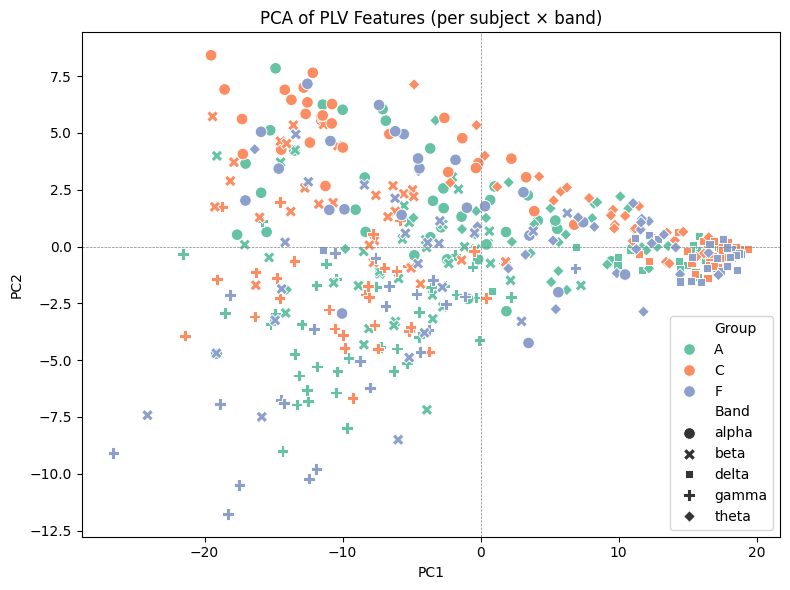

In [23]:
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Group": merged_df["Group"].values,
    "Subject": merged_df["subject"].values,
    "Band": merged_df["band"].values
})

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Group", style="Band", s=70, palette="Set2")
plt.title("PCA of PLV Features (per subject × band)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## clusterig


In [24]:
from sklearn.cluster import KMeans

# Fit KMeans with 3 clusters (assuming 3 groups: AD, FTD, CN)
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df["kmeans_cluster"] = kmeans.fit_predict(pca_df[["PC1", "PC2"]])


In [25]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
pca_df["gmm_cluster"] = gmm.fit_predict(pca_df[["PC1", "PC2"]])


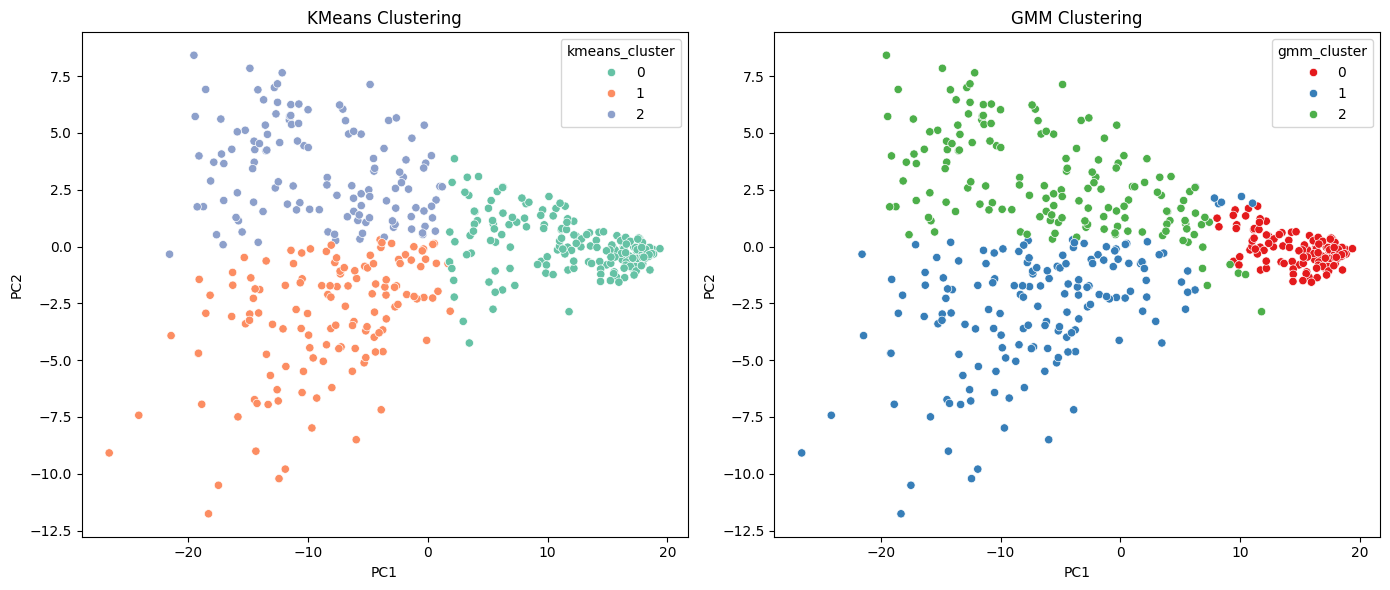

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# KMeans plot
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="kmeans_cluster", palette="Set2", ax=axs[0])
axs[0].set_title("KMeans Clustering")

# GMM plot
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="gmm_cluster", palette="Set1", ax=axs[1])
axs[1].set_title("GMM Clustering")

plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import calinski_harabasz_score

kmeans_score = calinski_harabasz_score(pca_df[["PC1", "PC2"]], pca_df["kmeans_cluster"])
gmm_score = calinski_harabasz_score(pca_df[["PC1", "PC2"]], pca_df["gmm_cluster"])

print(f"Calinski-Harabasz Score (KMeans): {kmeans_score:.2f}")
print(f"Calinski-Harabasz Score (GMM):    {gmm_score:.2f}")


Calinski-Harabasz Score (KMeans): 673.60
Calinski-Harabasz Score (GMM):    450.61


In [28]:
pd.crosstab(pca_df["Group"], pca_df["kmeans_cluster"], margins=True)


kmeans_cluster,0,1,2,All
Group,,,,
A,72,66,42,180
C,58,31,56,145
F,52,36,27,115
All,182,133,125,440


previous is pca + kmeans / GMM

## sparse pca 

In [31]:
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

# Standardize first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(plv_features_only)

# Sparse PCA: fewer components + sparsity
sparse_pca = SparsePCA(n_components=3, alpha=1, random_state=42)
X_sparse_pca = sparse_pca.fit_transform(X_scaled)

# Create a DataFrame
sparse_pca_df = pd.DataFrame({
    "PC1": X_sparse_pca[:, 0],
    "PC2": X_sparse_pca[:, 1],
    "Group": merged_df["Group"].values,
    "Subject": merged_df["subject"].values,
    "Band": merged_df["band"].values
})


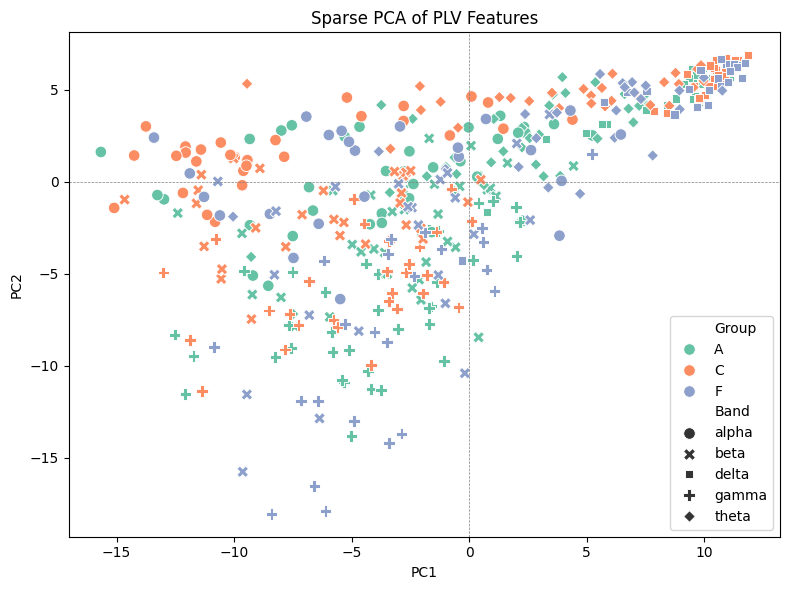

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=sparse_pca_df, x="PC1", y="PC2", hue="Group", style="Band", s=70, palette="Set2")
plt.title("Sparse PCA of PLV Features")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## kernel pca

In [38]:
from sklearn.decomposition import KernelPCA

# Try RBF kernel first
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=0.01)
X_kpca = kpca.fit_transform(X_scaled)

kpca_df = pd.DataFrame({
    "KPC1": X_kpca[:, 0],
    "KPC2": X_kpca[:, 1],
    "Group": merged_df["Group"].values,
    "Subject": merged_df["subject"].values,
    "Band": merged_df["band"].values
})


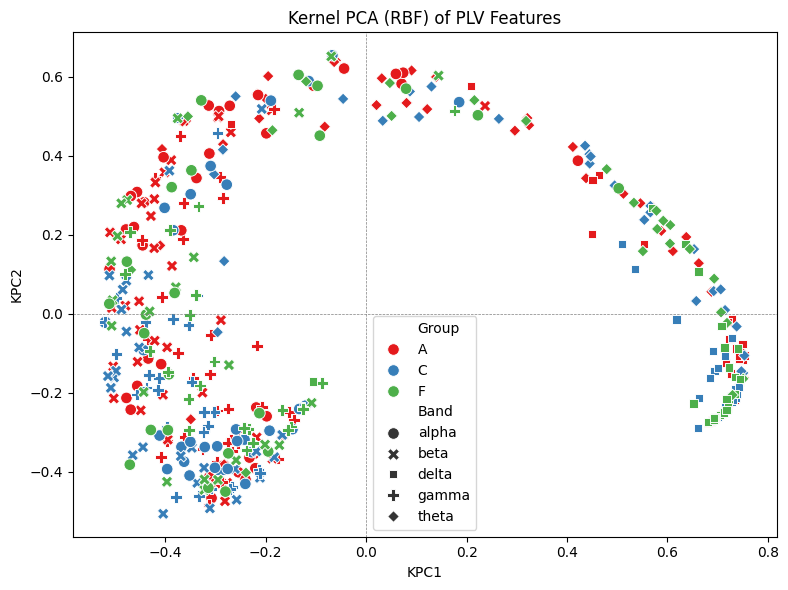

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=kpca_df, x="KPC1", y="KPC2", hue="Group", style="Band", s=70, palette="Set1")
plt.title("Kernel PCA (RBF) of PLV Features")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def evaluate_kmeans(X, max_k=10, title=""):
    inertias = []
    silhouettes = []

    K = range(2, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, labels))

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow plot
    ax[0].plot(K, inertias, marker='o')
    ax[0].set_title(f"Elbow Plot {title}")
    ax[0].set_xlabel("Number of clusters")
    ax[0].set_ylabel("Inertia")

    # Silhouette plot
    ax[1].plot(K, silhouettes, marker='s', color='orange')
    ax[1].set_title(f"Silhouette Score Plot {title}")
    ax[1].set_xlabel("Number of clusters")
    ax[1].set_ylabel("Silhouette Score")

    plt.tight_layout()
    plt.show()


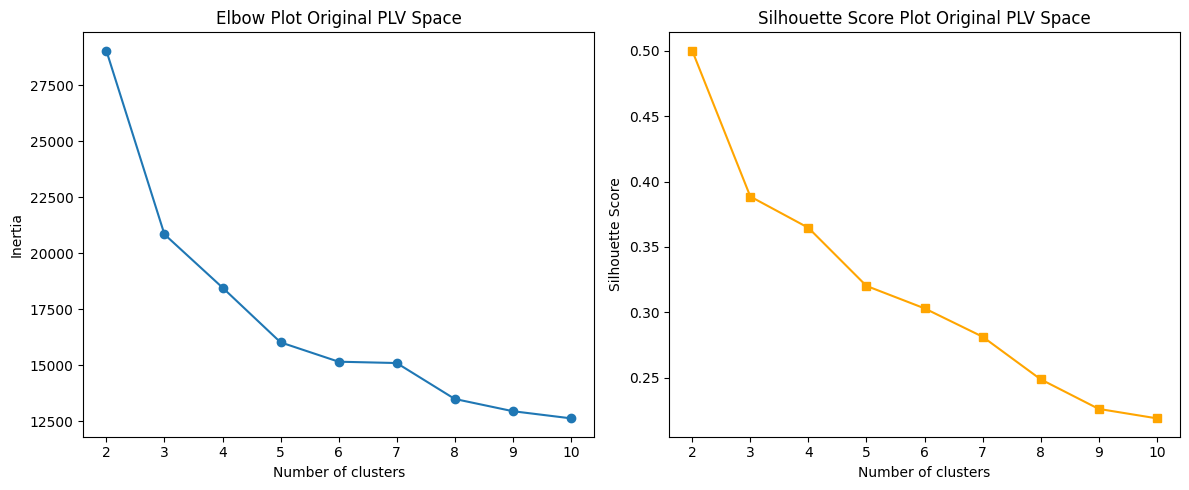

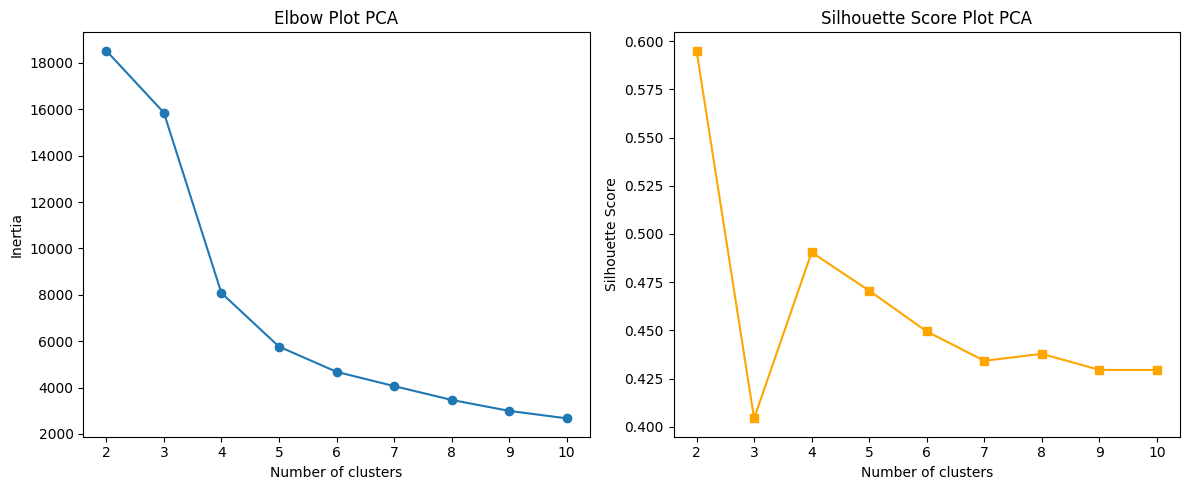

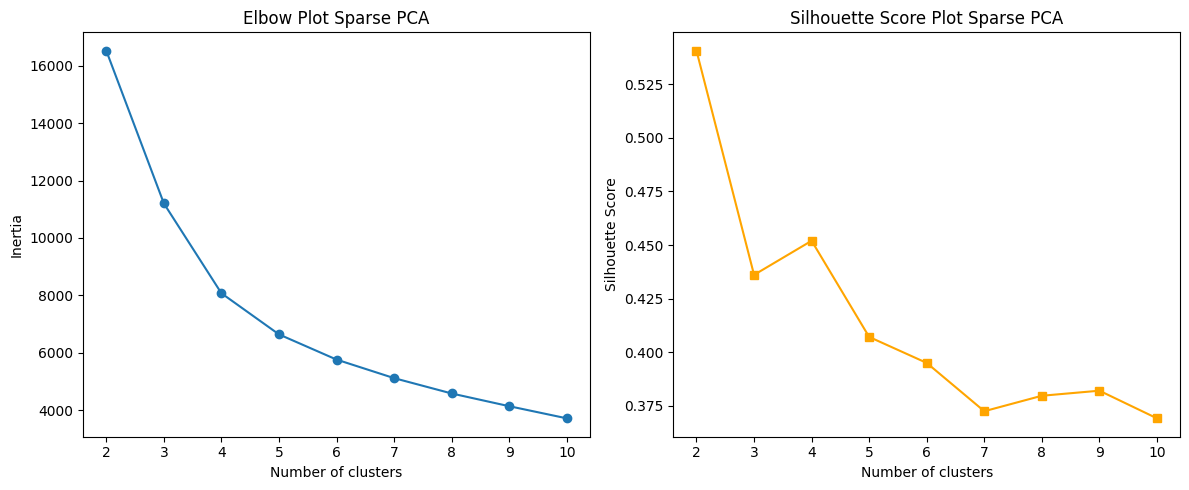

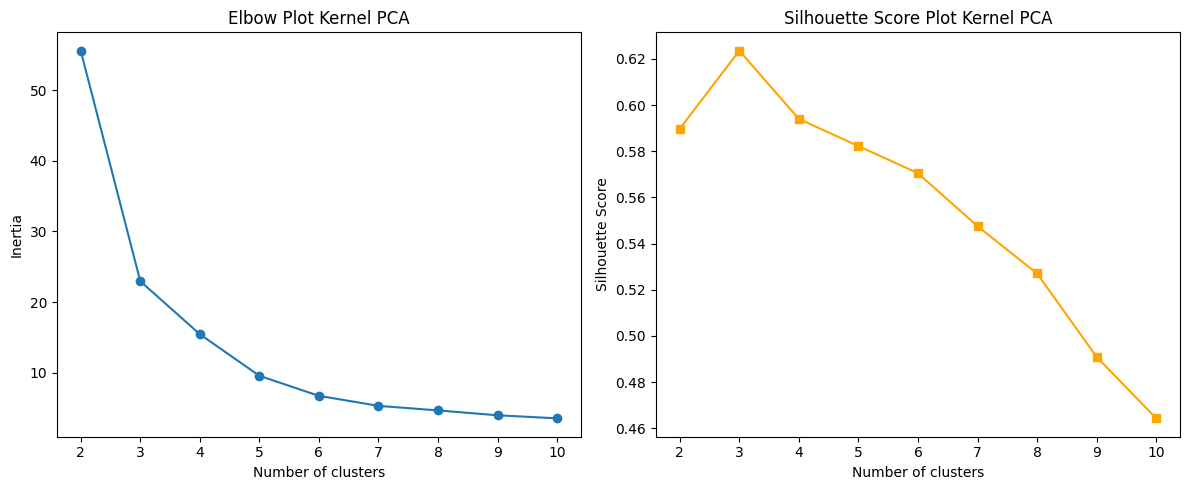

In [41]:
evaluate_kmeans(X_scaled, max_k=10, title="Original PLV Space")
evaluate_kmeans(X_pca, max_k=10, title="PCA")
evaluate_kmeans(X_sparse_pca, max_k=10, title="Sparse PCA")
evaluate_kmeans(X_kpca, max_k=10, title="Kernel PCA")


### Dendrograms from Kernel PCA embeddings

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dendrogram(X, method, metric, labels, title):
    # Compute distance matrix
    distance_matrix = pdist(X, metric=metric)
    
    # Compute linkage
    Z = linkage(distance_matrix, method=method)

    # Plot
    plt.figure(figsize=(14, 6))
    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=8)
    plt.title(f"Dendrogram - {method.capitalize()} linkage, {metric} distance")
    plt.xlabel("Subjects")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()


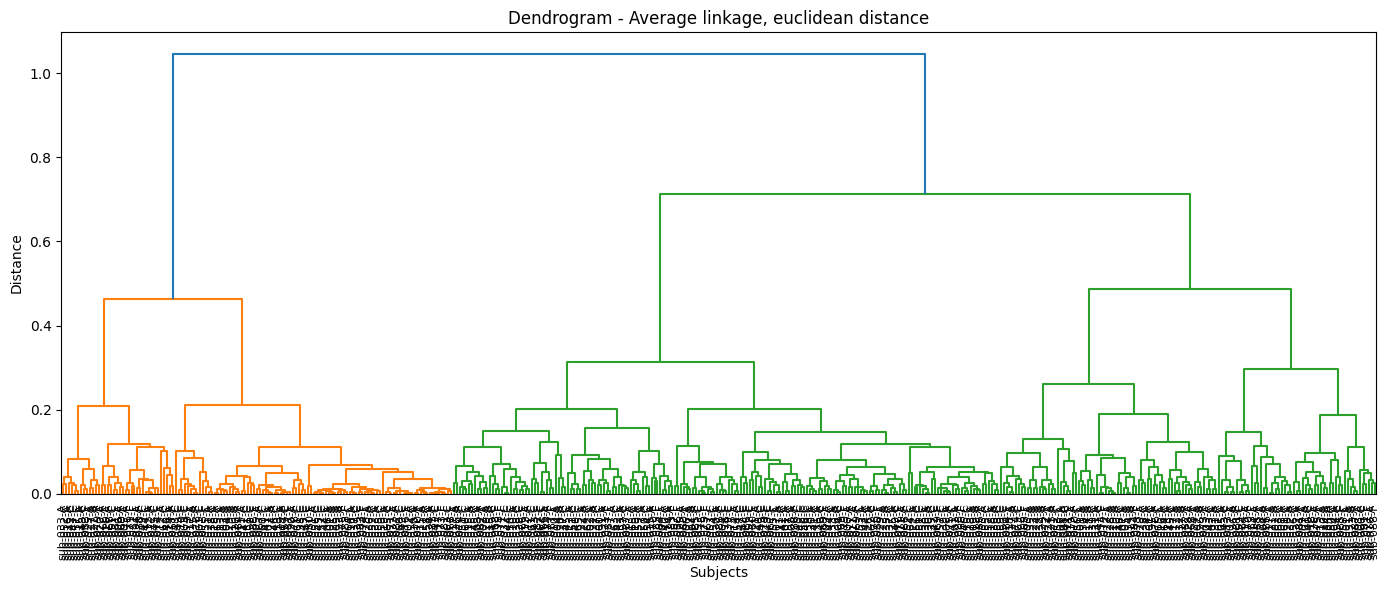

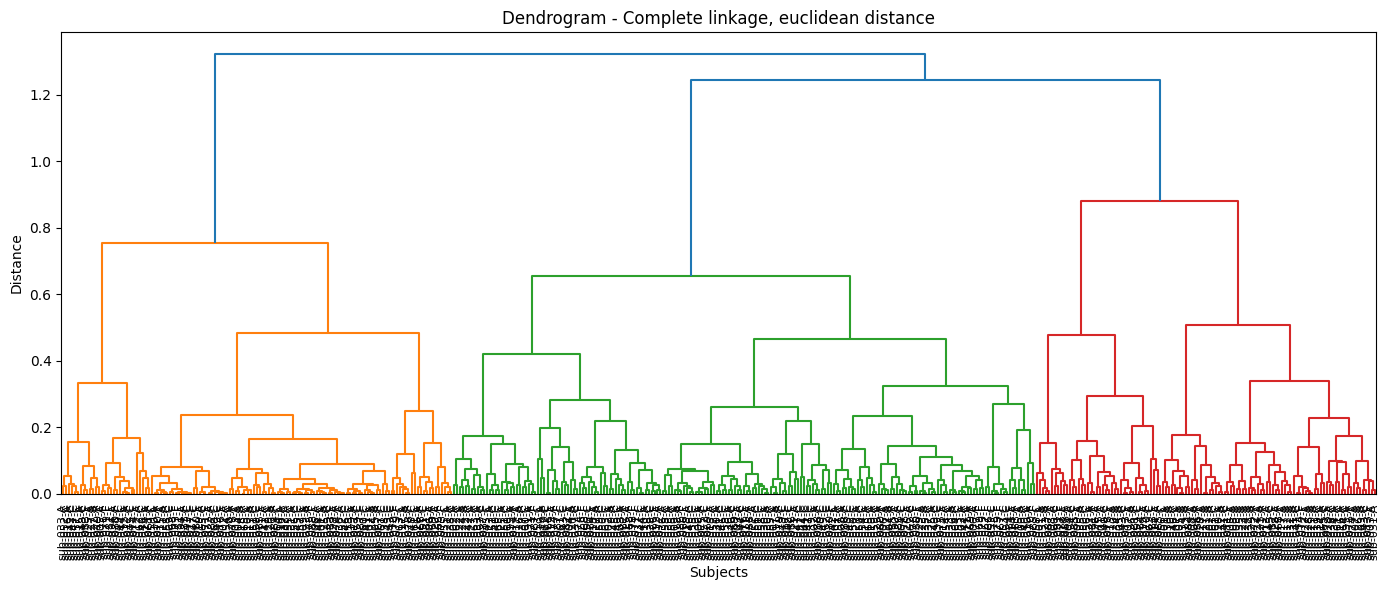

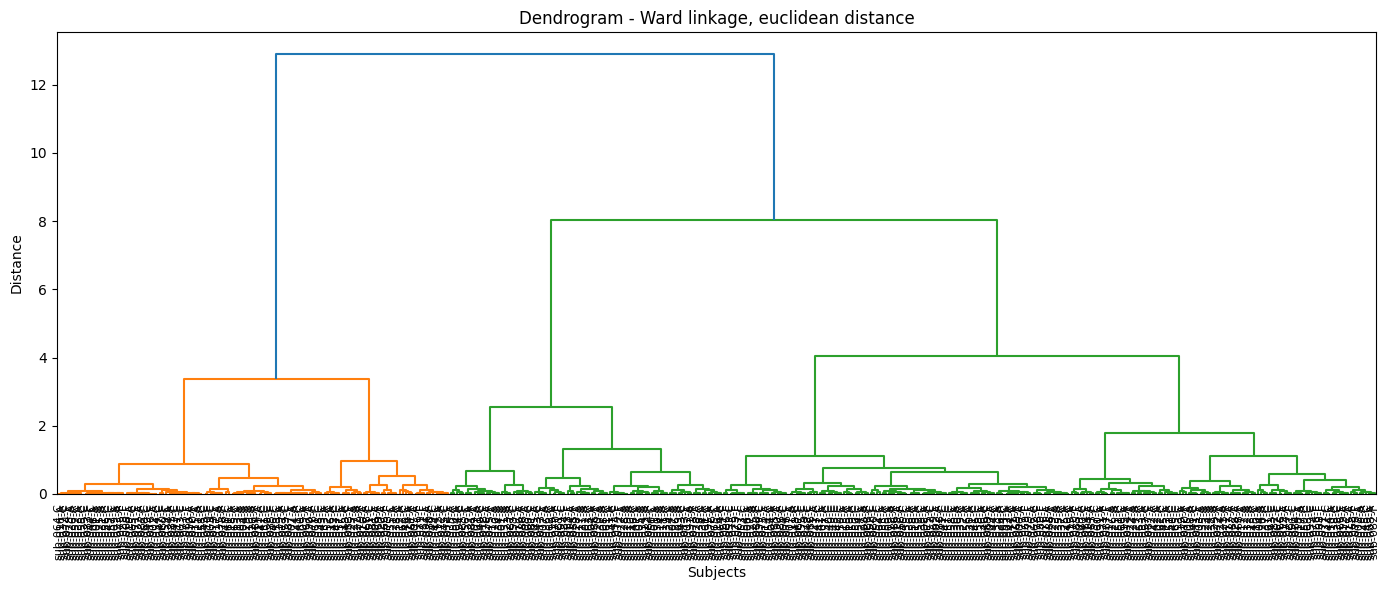

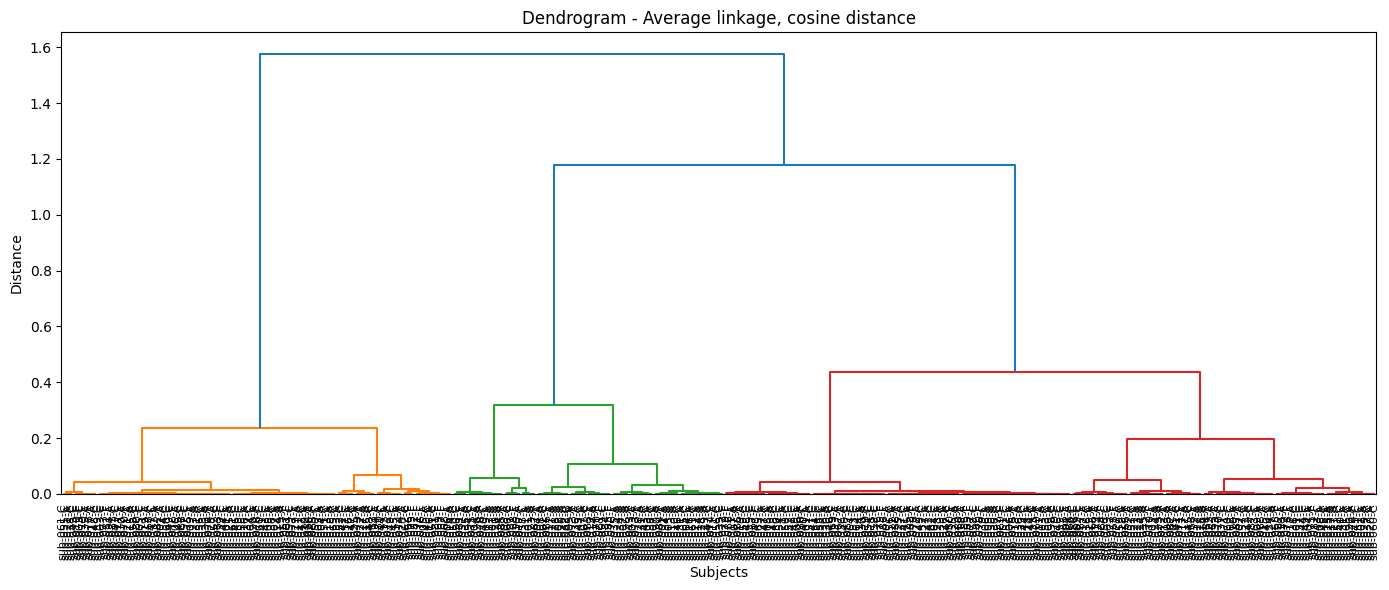

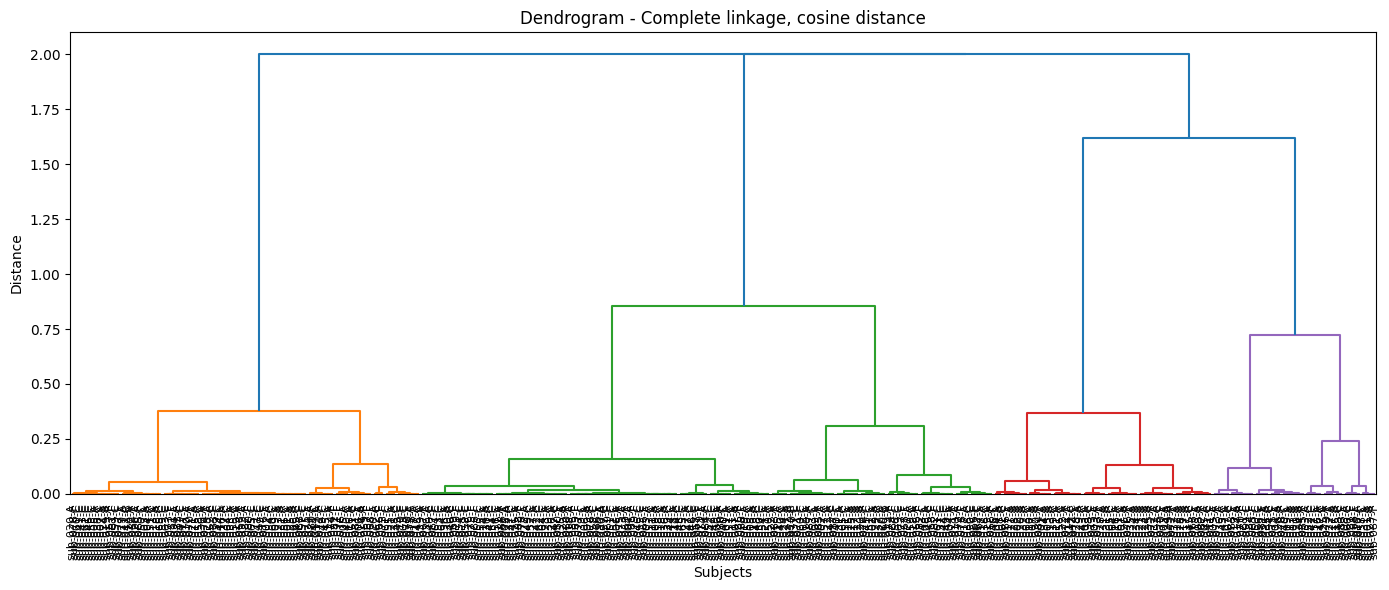

In [44]:
# Labels for leaves
labels = [f"{s}-{g}" for s, g in zip(merged_df["subject"], merged_df["Group"])]

# Euclidean distance
for method in ["average", "complete", "ward"]:
    if method == "ward":
        plot_dendrogram(X_kpca, method="ward", metric="euclidean", labels=labels, title="Kernel PCA")
    else:
        plot_dendrogram(X_kpca, method=method, metric="euclidean", labels=labels, title="Kernel PCA")

# Cosine distance (ward doesn't support cosine)
for method in ["average", "complete"]:
    plot_dendrogram(X_kpca, method=method, metric="cosine", labels=labels, title="Kernel PCA")


In [45]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd

# Use Kernel PCA embedding (2D)
distance_matrix = pdist(X_kpca, metric="euclidean")
Z_complete = linkage(distance_matrix, method="complete")

n_clusters = 3
cluster_labels = fcluster(Z_complete, n_clusters, criterion="maxclust")

kpca_df["cluster_complete_euclidean"] = cluster_labels

pd.crosstab(kpca_df["Group"], kpca_df["cluster_complete_euclidean"], margins=True)


cluster_complete_euclidean,1,2,3,All
Group,,,,
A,47,67,66,180
C,47,76,22,145
F,37,52,26,115
All,131,195,114,440


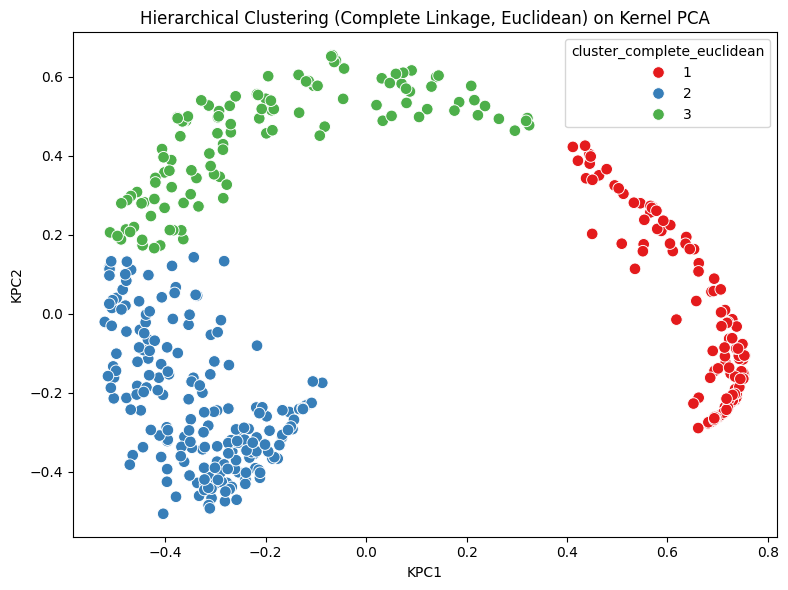

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=kpca_df, x="KPC1", y="KPC2",
                hue="cluster_complete_euclidean", palette="Set1", s=70)
plt.title("Hierarchical Clustering (Complete Linkage, Euclidean) on Kernel PCA")
plt.tight_layout()
plt.show()
